In [ ]:
import pyvisa
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time

In [ ]:
rm = pyvisa.ResourceManager()
instr = rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR")
instr.close()

In [3]:
with rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR") as instr:
    print(instr.query("*IDN?"))

RIGOL TECHNOLOGIES,DS4034,DS4A183300765,00.02.03



IDLE,0



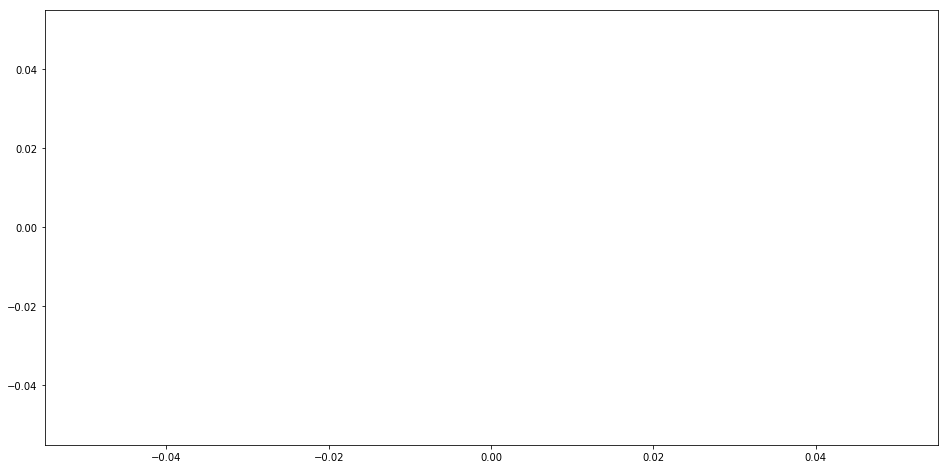

In [4]:
import time

with rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR") as instr:
    instr.write(":STOP")
    instr.write(":CLEAR")
    instr.write("WAV:SOUR CHAN1")
    instr.write(":SINGLE")
    instr.write("WAV:RES")
    instr.write("WAV:MODE RAW")
    instr.write("WAV:FORM BYTE")
    instr.write("WAV:POIN 1400")
    instr.write("WAV:STOP 1400")
    instr.write("WAV:BEG")
    print(instr.query("WAV:STAT?"))
    while instr.query("WAV:STAT?")[:4] != "IDLE":
        time.sleep(0.5)
        print(instr.query("WAV:STAT?"))
    data = instr.query_binary_values("WAV:DATA?", datatype = "B", container=np.array)
    instr.write("WAV:END")
    
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(data)

2,0,0,1,5.000000e-11,-1.500000e-08,0,6.250000e-03,108,127

112



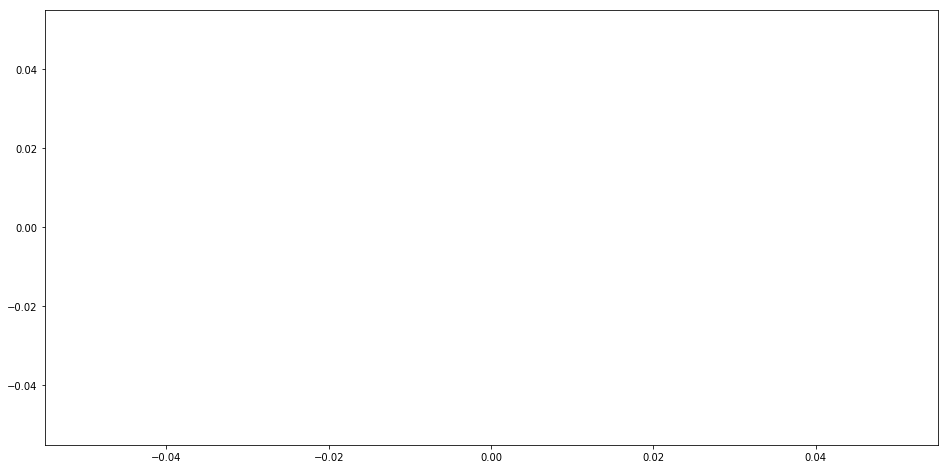

In [5]:
with rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR") as instr:
    instr.write(":RUN")
    instr.write("TIM:SCAL 2e-9")
    instr.write("WAV:MODE NORM")
    instr.write("WAV:POIN 1400")
    instr.write("WAV:FORM ASC")
    print(instr.query("WAV:PRE?"))
    print(instr.query("ACQ:MDEP?"))
    data = instr.query("WAV:DATA?")
data = [float(d) for d in data.split(',')[:-1]]

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(data)

0,0,1400,1,2.000000e-11,6.000001e-09,0,6.250000e-03,108,127

112

4.000000e+09



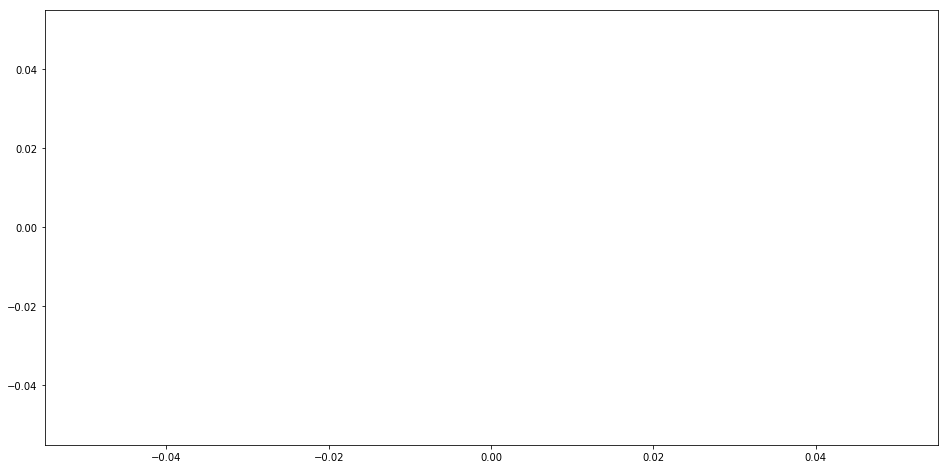

In [6]:
with rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR") as instr:
    instr.timeout = 2000
    instr.write(":SINGLE")
    instr.write("WAV:MODE NORM")
    instr.write("WAV:POIN 1400")
    instr.write("WAV:FORM BYTE")
    print(instr.query("WAV:PRE?"))
    print(instr.query("ACQ:MDEP?"))
    print(instr.query("ACQ:SRAT?"))
    data = instr.query_binary_values("WAV:DATA?", datatype = "B", container=np.array)

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(data)

In [7]:
def setCommand(instr, command):
    instr.write(command)
    cmd = instr.query(' '.join(command.split(' ')[:-1])+'?').strip('\n')
    arg = command.split(' ')[-1]
    assert cmd == arg, '{0}; parameter not set, {1} -> {2}'.format(command, cmd, arg)

In [23]:
from tqdm import tqdm
import time

def acquire_single_photons_testing(iterations, compression = None, **kwargs):
    with rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR") as instr:
        points = kwargs['POINTS']
        instr.write(":STOP")
        setCommand(instr,"{0}:COUP {1}".format(kwargs['CHANNEL'], kwargs['COUPLING']))
        setCommand(instr,"{0}:IMP {1}".format(kwargs['CHANNEL'], kwargs['IMPEDANCE']))
        instr.write("{0}:OFFS {1}".format(kwargs["CHANNEL"], kwargs["CHANNEL_OFFSET"]))
        instr.write("{0}:SCAL {1}".format(kwargs["CHANNEL"], kwargs['CHANNEL_SCALE']))
        setCommand(instr,"{0}:BWL {1}".format(kwargs["CHANNEL"], kwargs["BANDWIDTH"]))
        instr.write("TIM:OFFS {0}".format(kwargs['TIME_OFFSET']))
        instr.write("TIM:SCAL {0}".format(kwargs['TIME_SCALE']))
        setCommand(instr,"TRIG:COUP {0}".format(kwargs['TRIG_COUPLING']))
        setCommand(instr,"TRIG:MODE {0}".format(kwargs['TRIG_MODE']))
        setCommand(instr,"TRIG:SWE {0}".format(kwargs['TRIG_SWE']))
        instr.write("TRIG:EDG:LEV {0}".format(kwargs['TRIG_LEVEL']))
        setCommand(instr,"TRIG:EDG:SLOP {0}".format(kwargs["TRIG_SLOPE"]))
        setCommand(instr,"TRIG:EDG:SOUR {0}".format(kwargs['CHANNEL']))
        setCommand(instr,"WAV:SOUR {0}".format(kwargs['CHANNEL']))
        setCommand(instr,"WAV:MODE {0}".format(kwargs['MODE']))
#         setCommand(instr,"WAV:POIN {0}".format(points))
        setCommand(instr,"WAV:FORM {0}".format(kwargs['FORMAT']))
        preamb = instr.query("WAV:PRE?").split(',')
        time.sleep(5)
        print(preamb)
            
        fig, ax = plt.subplots(figsize = (16,12))
        ax.axhline(kwargs['TRIG_LEVEL'], lw = 3, color ='k')
        for iteration in tqdm(range(iterations)):
            breakBool = False
            instr.write(":CLEAR")
            instr.write(":SINGLE")
            t = time.time()
            while True:
                if instr.query('TRIG:STAT?') == "STOP\n":
                    break
                if time.time()-t > 5:
                    breakBool = True
                    break
            if breakBool:
                break
            time.sleep(0.5)
            data = instr.query_binary_values("WAV:DATA?", datatype = "B", container=np.array)
            t = time.time()
            while len(data) == 0:
                data = instr.query_binary_values("WAV:DATA?", datatype = "B", container=np.array)
                if time.time()-t > 5:
                    breakBool = True
                    break
            if breakBool:
                break
            ax.plot((data.astype(np.int16)-(int(preamb[8])+int(preamb[9])))*float(preamb[7]))

['0', '0', '1400', '1', '9.999999e-10', '-3.500001e-07', '0', '3.125000e-03', '70', '127\n']


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


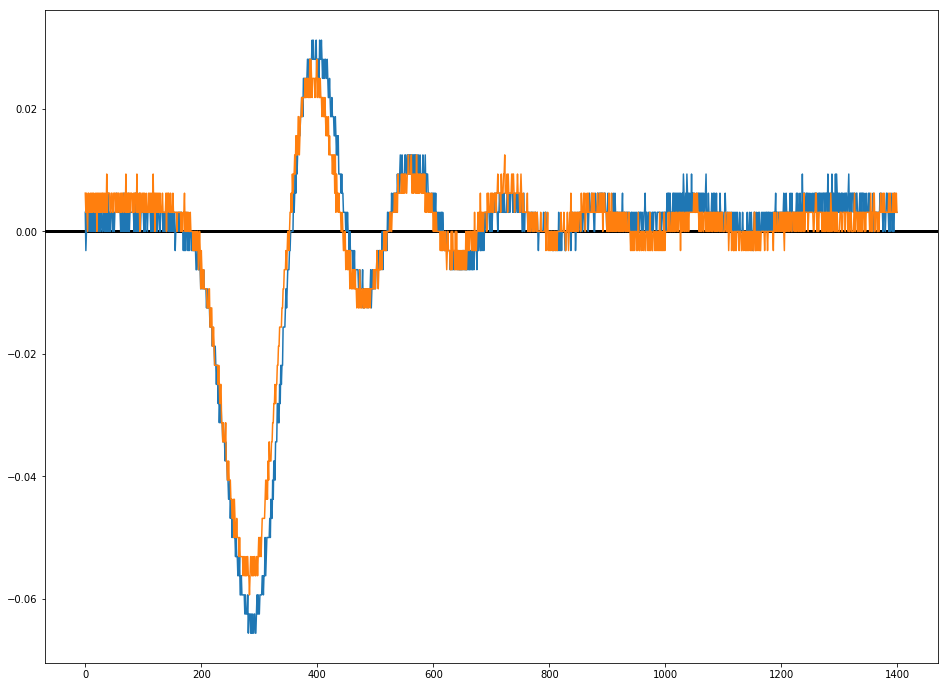

In [44]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': 220e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 350e-9, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': 0, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
d = acquire_single_photons_testing(2, **kwargs)

In [33]:
from tqdm import tqdm

def acquire_single_photons(fname, iterations, compression = None, **kwargs):
    with rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR") as instr:
        points = kwargs['POINTS']
        instr.write(":STOP")
        instr.write("{0}:COUP {1}".format(kwargs['CHANNEL'], kwargs['COUPLING']))
        instr.write("{0}:IMP {1}".format(kwargs['CHANNEL'], kwargs['IMPEDANCE']))
        instr.write("{0}:OFFS {1}".format(kwargs["CHANNEL"], kwargs["CHANNEL_OFFSET"]))
        instr.write("{0}:SCAL {1}".format(kwargs["CHANNEL"], kwargs['CHANNEL_SCALE']))
        instr.write("TIM:OFFS {0}".format(kwargs['TIME_OFFSET']))
        instr.write("TIM:SCAL {0}".format(kwargs['TIME_SCALE']))
        instr.write("TRIG:COUP {0}".format(kwargs['TRIG_COUPLING']))
        instr.write("TRIG:MODE {0}".format(kwargs['TRIG_MODE']))
        instr.write("TRIG:SWE {0}".format(kwargs['TRIG_SWE']))
        instr.write("TRIG:EDG:LEV {0}".format(kwargs['TRIG_LEVEL']))
        instr.write("TRIG:EDG:SLOP {0}".format(kwargs["TRIG_SLOPE"]))
        instr.write("TRIG:EDG:SOUR {0}".format(kwargs['CHANNEL']))
        instr.write("WAV:SOUR {0}".format(kwargs['CHANNEL']))
        instr.write("WAV:MODE {0}".format(kwargs['MODE']))
        instr.write("WAV:POIN {0}".format(points))
        instr.write("WAV:FORM {0}".format(kwargs['FORMAT']))
        time.sleep(5)
        preamb = instr.query("WAV:PRE?").split(',')
        

        with h5py.File(fname+'.hdf5', 'w') as f:
            grp = f.create_group('peaks')
            
            grp.attrs['trig_level'] = kwargs['TRIG_LEVEL']
            grp.attrs['trig_slope'] = kwargs['TRIG_SLOPE']
            grp.attrs['bandwidth'] = kwargs['BANDWIDTH']
            grp.attrs['impedance'] = kwargs['IMPEDANCE']
            grp.attrs['coupling'] = kwargs['COUPLING']
            grp.attrs['nr_averages'] = int(preamb[3])
            grp.attrs['x_increment'] = preamb[4]
            grp.attrs['x_origin'] = preamb[5]
            grp.attrs['y_increment'] = preamb[7]
            grp.attrs['y_origin'] = int(preamb[8])+int(preamb[9])
        
        for iteration in tqdm(range(iterations)):
            breakBool = False
            instr.write(":CLEAR")
            instr.write(":SINGLE")

            t = time.time()
            while True:
                if instr.query('TRIG:STAT?') == "STOP\n":
                    break
                elif time.time()-t > 5:
                    breakBool = True
                    print('timeout: TRIG:STAT? != STOP')
                    break
                else:
                    time.sleep(0.1)
            if breakBool:
                break

            data = instr.query_binary_values("WAV:DATA?", datatype = "B", container=np.array)
            time.sleep(0.5)

            t = time.time()
            while len(data) == 0:
                data = instr.query_binary_values("WAV:DATA?", datatype = "B", container=np.array)
                time.sleep(0.1)
                instr.write(":CLEAR")
                instr.write(":SINGLE")
                time.sleep(0.5)
                if time.time()-t > 10:
                    breakBool = True
                    print('timeout: WAV:DATA? empty {}'.format(iteration))
                    break
            if breakBool:
                break

            with h5py.File(fname+'.hdf5', 'a') as f:
                grp = f['/peaks']
                if compression == None:
                    dset = grp.create_dataset("peak_{0}".format(iteration), (points, ), dtype = np.uint8)
                else:
                    dset = grp.create_dataset("peak_{0}".format(iteration), (points, ), dtype = np.uint8, compression="gzip", compression_opts = compression)
                dset[:] = data

In [ ]:
d = acquire_single_photons('single_photons_lightson_50Ohm_ampstage12_scope_1400V', 2000, **kwargs)

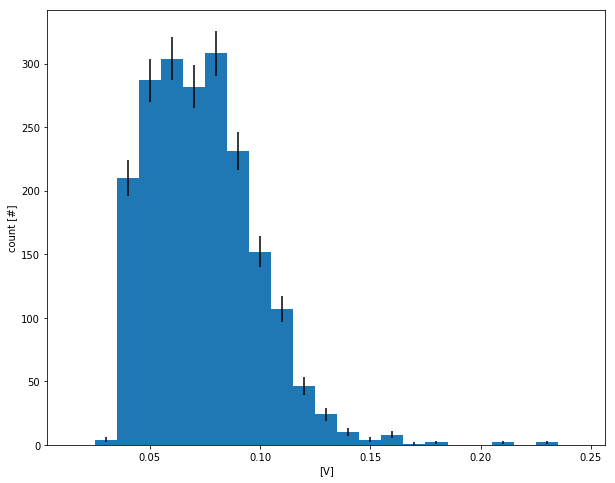

In [12]:
fname = 'single_photons_lightson_50Ohm_ampstage12_scope_1400V'
data = []
with h5py.File(fname+'.hdf5', 'r') as f:
    attrs = dict(f['peaks/'].attrs)
    gain = float(attrs['y_increment'])
    offset = int(attrs['y_origin'])
    for dset in f['peaks/']:
        values = (f['peaks/{0}'.format(dset)].value.astype(np.int16)-offset)*gain
        data.append((dset, values, values.min()))

bins = np.arange(0.01, 0.25, 1e-2)

tmp = [-1*d[2] for d in data]
fig, ax = plt.subplots(figsize = (10,8))
hist1400, edges1400 = np.histogram(tmp, bins = bins)
center1400 = np.diff(edges1400)[0]+edges1400[:-1]
ax.bar(center1400, hist1400, yerr = np.round(np.sqrt(hist1400)), width = np.diff(edges1400)[0])
ax.set_xlabel('[V]')
ax.set_ylabel('count [#]');

In [ ]:
acquire_single_photons('single_photons_lightson_50Ohm_ampstage12_scope_1100V', 2000, **kwargs)

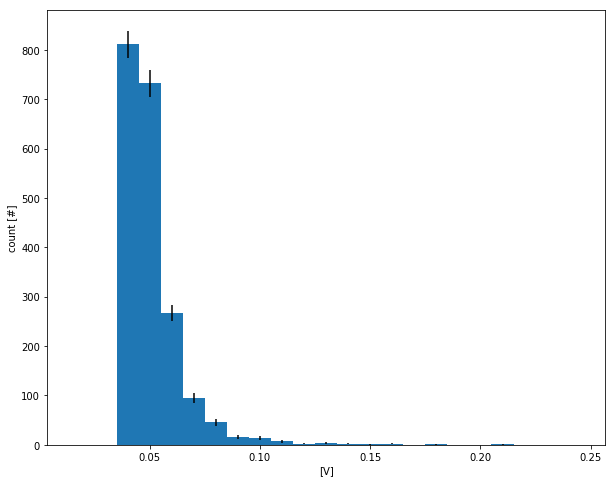

In [13]:
fname = 'single_photons_lightson_50Ohm_ampstage12_scope_1100V'
data = []
with h5py.File(fname+'.hdf5', 'r') as f:
    attrs = dict(f['peaks/'].attrs)
    gain = float(attrs['y_increment'])
    offset = int(attrs['y_origin'])
    for dset in f['peaks/']:
        values = (f['peaks/{0}'.format(dset)].value.astype(np.int16)-offset)*gain
        data.append((dset, values, values.min()))
        
tmp = [-1*d[2] for d in data]
fig, ax = plt.subplots(figsize = (10,8))
hist1100, edges1100 = np.histogram(tmp, bins = bins)
center1100 = np.diff(edges1100)[0]+edges1100[:-1]
ax.bar(center1100, hist1100, yerr = np.round(np.sqrt(hist1100)), width = np.diff(edges1100)[0])
ax.set_xlabel('[V]')
ax.set_ylabel('count [#]');

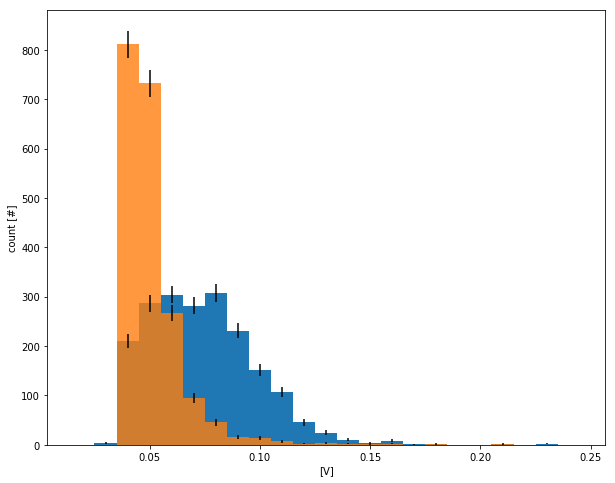

In [14]:
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(center1400, hist1400, yerr = np.round(np.sqrt(hist1400)), width = np.diff(edges1400)[0])
ax.bar(center1100, hist1100, yerr = np.round(np.sqrt(hist1100)), width = np.diff(edges1100)[0], alpha = 0.8)
ax.set_xlabel('[V]')
ax.set_ylabel('count [#]');

In [ ]:
kwargs = {'COUPLING': 'AC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': 340e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 2e-8, 'TIME_SCALE': 5e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': -110e-3, 'TRIG_SLOPE': 'NEG', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('single_photons_lightson_50Ohm_ampstage123_scope_1100V', 2000, **kwargs)

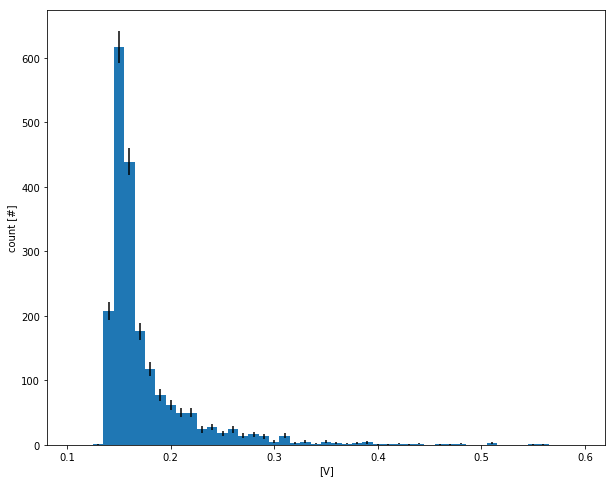

In [15]:
fname = 'single_photons_lightson_50Ohm_ampstage123_scope_1100V'
data = []
with h5py.File(fname+'.hdf5', 'r') as f:
    attrs = dict(f['peaks/'].attrs)
    gain = float(attrs['y_increment'])
    offset = int(attrs['y_origin'])
    for dset in f['peaks/']:
        values = (f['peaks/{0}'.format(dset)].value.astype(np.int16)-offset)*gain
        data.append((dset, values, values.min()))

bins = np.arange(0.1, 0.6, 1e-2)
        
tmp = [-1*d[2] for d in data]
fig, ax = plt.subplots(figsize = (10,8))
hist1100_123, edges1100_123 = np.histogram(tmp, bins = bins)
center1100_123 = np.diff(edges1100_123)[0]+edges1100_123[:-1]
ax.bar(center1100_123, hist1100_123, yerr = np.round(np.sqrt(hist1100_123)), width = np.diff(edges1100_123)[0])
ax.set_xlabel('[V]')
ax.set_ylabel('count [#]');

In [16]:
kwargs = {'COUPLING': 'AC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': 680e-3, 'CHANNEL_SCALE': 20e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 2e-8, 'TIME_SCALE': 5e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': -110e-3, 'TRIG_SLOPE': 'NEG', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('single_photons_lightson_50Ohm_ampstage123_scope_1400V', 2000, **kwargs)

100%|██████████| 2000/2000 [33:11<00:00,  1.00s/it]


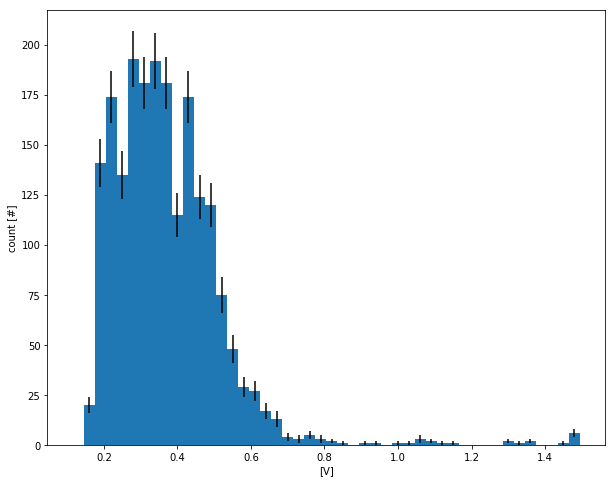

In [20]:
fname = 'single_photons_lightson_50Ohm_ampstage123_scope_1400V'
data = []
with h5py.File(fname+'.hdf5', 'r') as f:
    attrs = dict(f['peaks/'].attrs)
    gain = float(attrs['y_increment'])
    offset = int(attrs['y_origin'])
    for dset in f['peaks/']:
        values = (f['peaks/{0}'.format(dset)].value.astype(np.int16)-offset)*gain
        data.append((dset, values, values.min()))

bins = np.arange(0.1, 1.5, 3e-2)
        
tmp = [-1*d[2] for d in data]
fig, ax = plt.subplots(figsize = (10,8))
hist1100_123, edges1100_123 = np.histogram(tmp, bins = bins)
center1100_123 = np.diff(edges1100_123)[0]+edges1100_123[:-1]
ax.bar(center1100_123, hist1100_123, yerr = np.round(np.sqrt(hist1100_123)), width = np.diff(edges1100_123)[0])
ax.set_xlabel('[V]')
ax.set_ylabel('count [#]');

In [32]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': 0, 'CHANNEL_SCALE': 2e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 0, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': -12e-3, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('sinusoidal_ampcheck', 60, **kwargs)

100%|██████████| 60/60 [00:54<00:00,  1.02it/s]


In [35]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': -64e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 0, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': -12e-3, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('sinusoidal_ampcheck_stage1', 60, **kwargs)

100%|██████████| 60/60 [00:55<00:00,  1.07it/s]


In [42]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': -166e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 0, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': 80e-3, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('sinusoidal_ampcheck_stage2', 60, **kwargs)

100%|██████████| 60/60 [00:53<00:00,  1.14it/s]


In [41]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': -166e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 0, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': 80e-3, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('sinusoidal_ampcheck_stage3', 60, **kwargs)

100%|██████████| 60/60 [00:56<00:00,  1.02s/it]


In [40]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': -166e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 0, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': 80e-3, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('sinusoidal_ampcheck_stage4', 60, **kwargs)

100%|██████████| 60/60 [00:56<00:00,  1.04s/it]


In [45]:
kwargs = {'COUPLING': 'DC', 'CHANNEL': 'CHAN1', 'IMPEDANCE': 'FIFT', 'CHANNEL_OFFSET': 220e-3, 'CHANNEL_SCALE': 10e-2,
          'BANDWIDTH': 'OFF',
          'TIME_OFFSET': 350e-9, 'TIME_SCALE': 100e-9, 'TRIG_COUPLING': 'DC', 'TRIG_MODE': 'EDGE', 'TRIG_SWE': 'NORM', 
          'TRIG_LEVEL': 0, 'TRIG_SLOPE': 'POS', 'MODE': 'NORM', 'POINTS': 1400, 'FORMAT':'BYTE'}
acquire_single_photons('single_photons_lightson_50Ohm_ampstage123_scope_1400V_5MHzLowPass', 2000, **kwargs)

100%|██████████| 2000/2000 [29:15<00:00,  1.08s/it]
